# SEP criterion : reg_mul = 0.003

In [1]:
# preparation of the environment

%load_ext autoreload
%autoreload 2

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
foler_name = "reg_mul=0.003"
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, foler_name)
if not path.exists(graph_folder):
    os.mkdir(graph_folder)

print(f">> the plots location : {graph_folder}")

import pandas as pd
import torch
import numpy as np
import pickle
from tqdm import tqdm
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from regularize_training_bert import BertNliRegu
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention

ckp = path.join(".cache", "logs", "igrida_trained", "reg_mul=0.003", "best.ckpt")
model = BertNliRegu.load_from_checkpoint(ckp)
model = model.eval()  # make sure to have the model in eval mod before using it

# load the data >> without the neutral labels
data_set = SnliDataset(dir=test_dir,
                       nb_sentences=1000,
                       msg=False,
                       keep_neutral=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\reg_mul=0.003


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

## The different metrics

In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc

In [3]:
def jaccard(y, y_hat):
    num = np.dot(y,y_hat)
    den = np.sum(y) + np.sum(y_hat) - np.dot(y, y_hat)
    return num/den

## What SEP to choose

In a given sentence there is two sep values we will see if there is a difference between the two sep values in the attention (box plot of the attention on the two sep values)

In [4]:
d = {}
for layer in range(12):
    for head in range(12):
        d[(layer, head)] = [], []

for i in tqdm(range(len(sentences))):
    sent = sentences[i, :].clone().detach()[None, :]
    mk = masks[i, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )
    sep_idx = np.where(np.array(raw_attention_inst.tokens)=="[SEP]")[0]

    for layer in range(12):
        for head in range(12):
            test_1 = raw_attention_inst.attention_tensor[0, layer, head, 0, sep_idx[0]].item()
            test_2 = raw_attention_inst.attention_tensor[0, layer, head, 0, sep_idx[1]].item()
            d[(layer, head)][0].append(test_1)
            d[(layer, head)][0].append(test_2)

            d[(layer, head)][1].append("SEP 1")
            d[(layer, head)][1].append("SEP_2")


100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


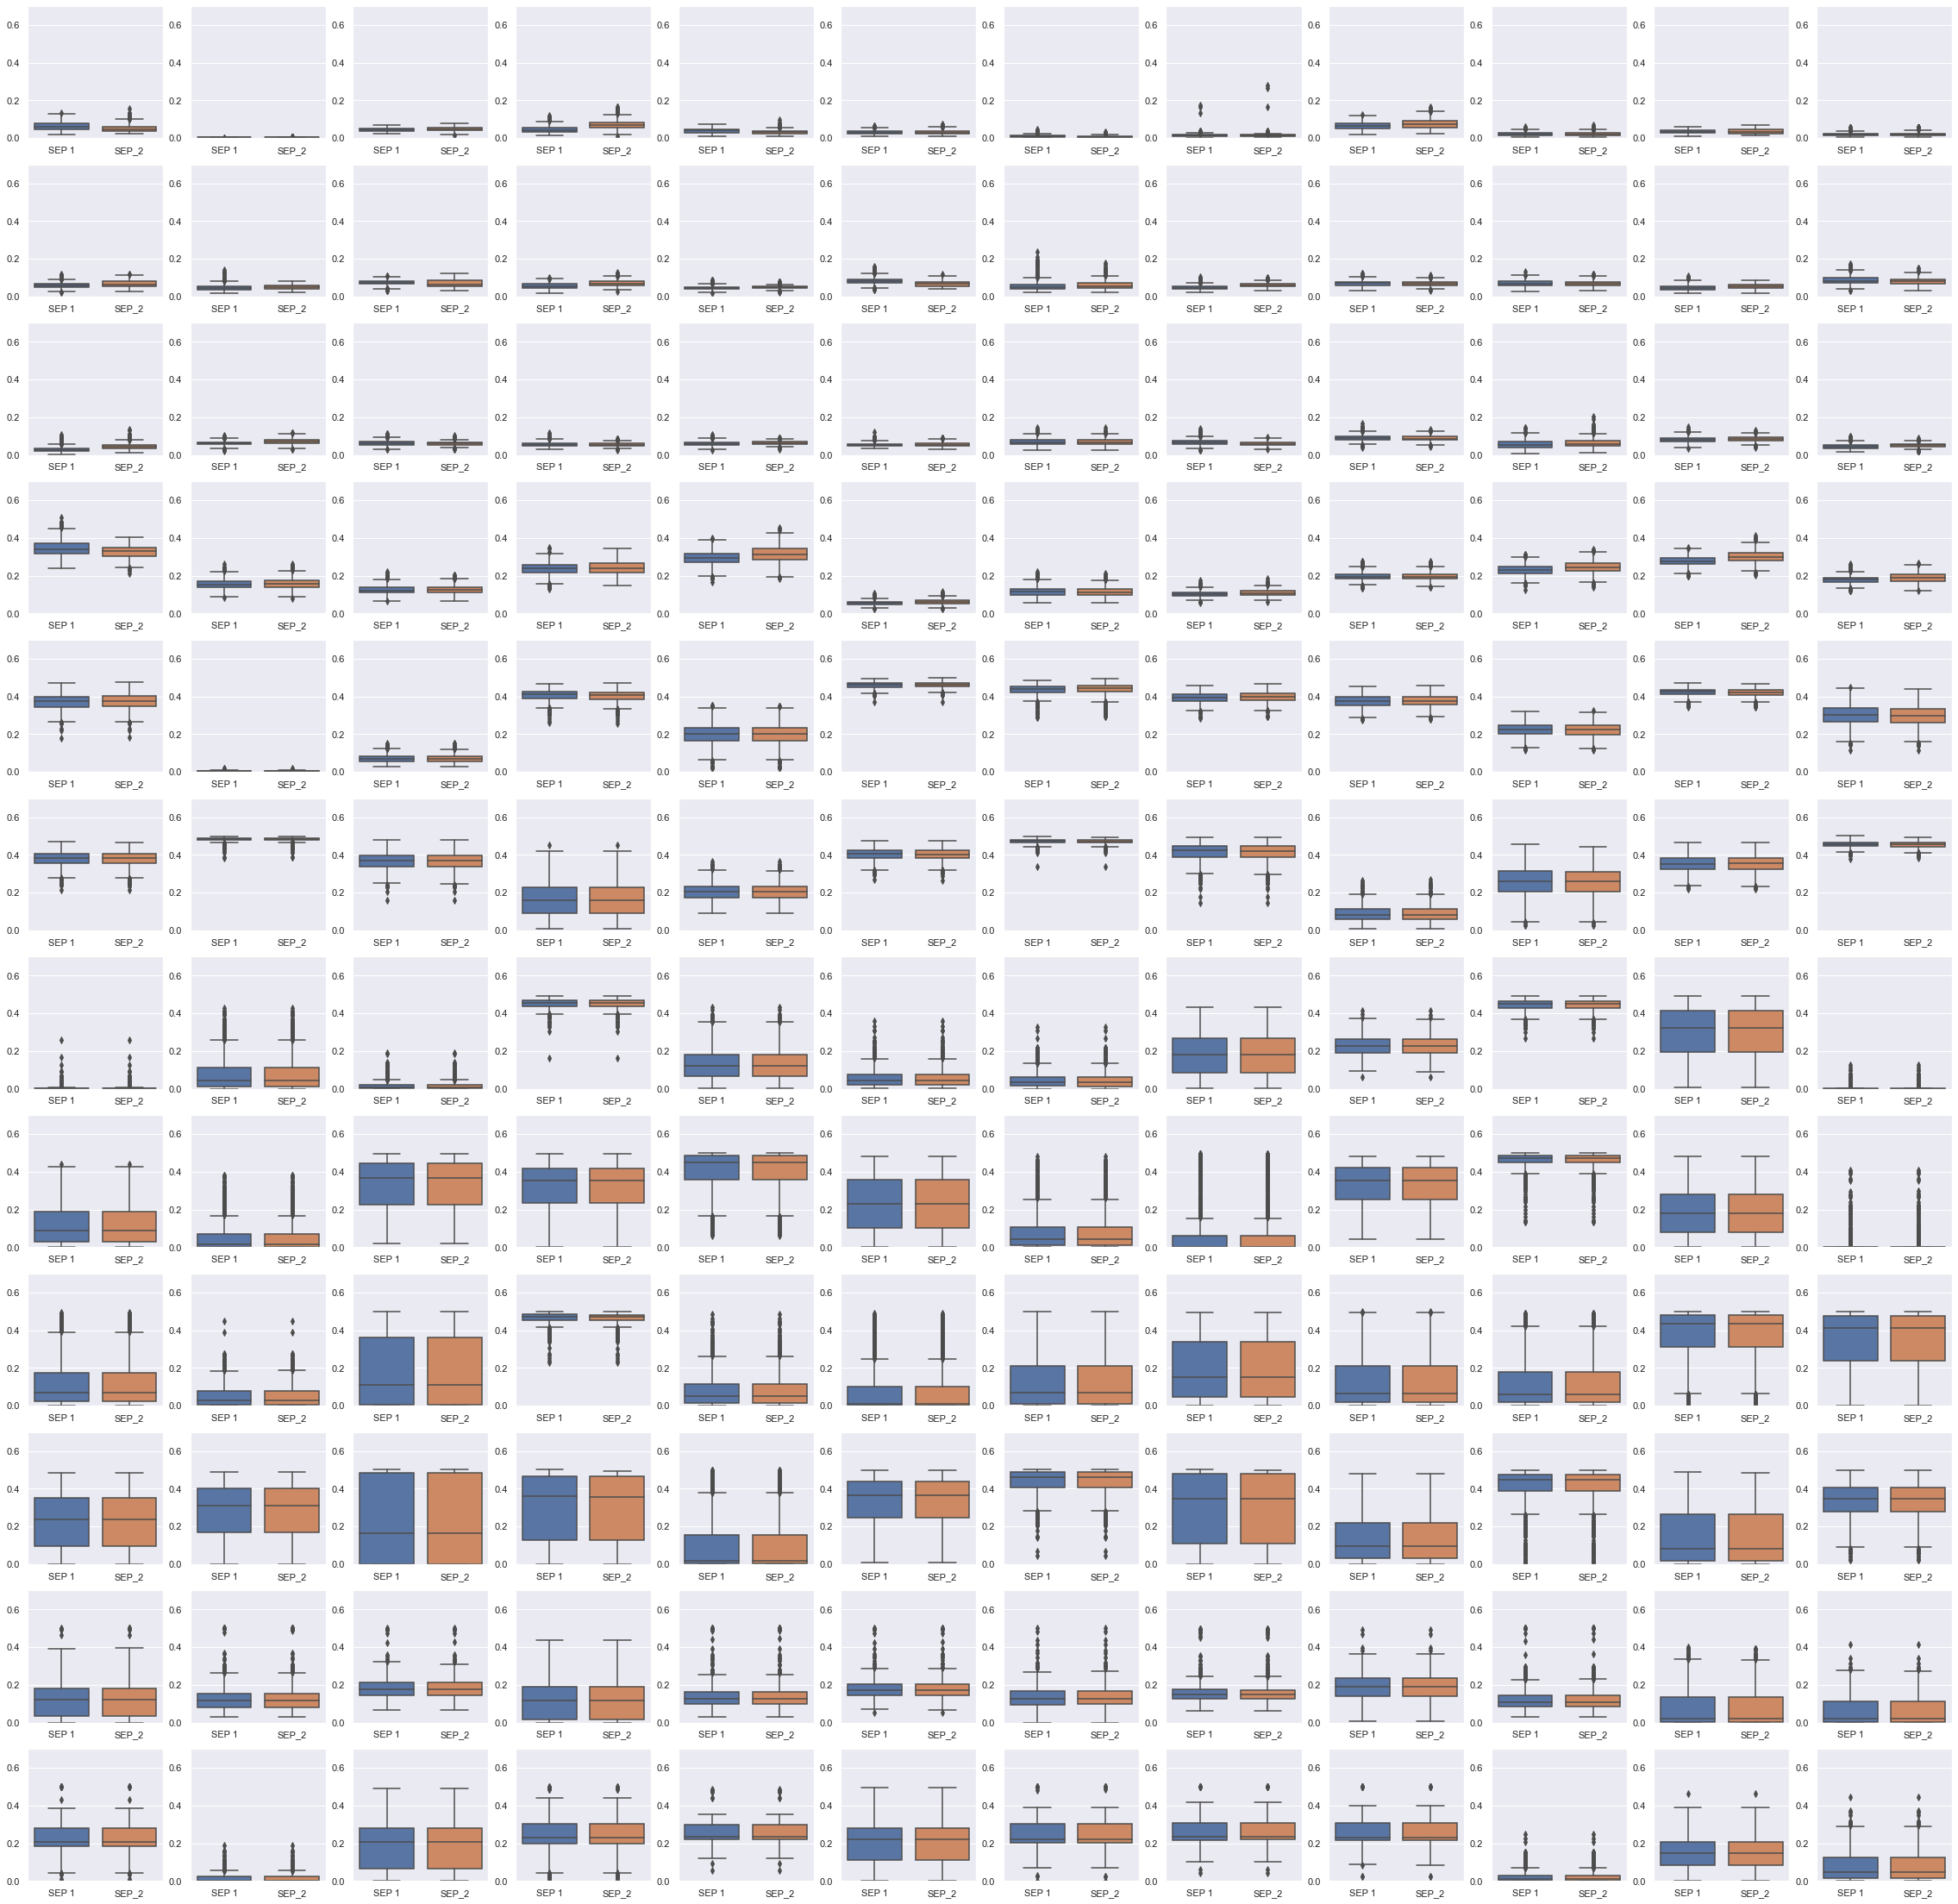

In [5]:
fig, axes = plt.subplots(12,12, figsize=(40,40))
for layer in range(12):
    for head in range(12):
        ax = axes[layer, head]
        ax.set_ylim(0, 0.7)
        sns.boxplot(x = d[(layer, head)][1], y = d[(layer, head)][0], ax = ax)

plt.savefig(os.path.join(graph_folder, "SEP_attention.png"))

It seems like there is no difference between the values of the two SEP, then we will take the mean of the two values for our criterion of head selection

## Functions for the Study

In [4]:
def sep_criterion(sep_tr,sentences=sentences, masks=masks, msg = False):
    y_hat = []
    y = []
    for i in tqdm(range(len(sentences))):
        sent = sentences[i, :].clone().detach()[None, :]
        mk = masks[i, :].clone().detach()[None, :]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # search for the right sentence in the snli dataset
        j = 0
        while j < e_snli_data.shape[0] and raw_attention_inst.tokens != eval(e_snli_data["tok_sent"][j]):
            j += 1

        try :
            # update the annotation list
            annot = eval(e_snli_data.hg_goal[j])
            y += annot

            # construction of the attention_score based on the SEP criterion
            sep_idx = np.where(np.array(raw_attention_inst.tokens)=="[SEP]")[0]
            attention_score = torch.zeros(len(raw_attention_inst.tokens))
            for layer in range(12):
                for head in range(12):
                    buff = raw_attention_inst.attention_tensor[0, layer, head, 0, :]
                    test = (buff[sep_idx[0]].item() + buff[sep_idx[1]].item()) / 2 # mean of the two values
                    if test <= sep_tr: # this is the criterion to proceed the head selection
                        attention_score += buff
            # transform to a list
            attention_score = list(normalize_attention(tokens=raw_attention_inst.tokens,
                                                       attention=attention_score).detach().numpy())
            y_hat += attention_score


        except Exception as e:
            if msg :
                print(e)
            else :
                pass
    return {"y" : y, "y_hat": y_hat}

In [5]:
def create_row(y, y_hat, metrics):
    row = []
    tr = np.linspace(0, 1, 50)
    for m in metrics :
        if m != "roc_auc_score" and m != "jaccard" and m != "average_precision_score":
            ar = [] # --> calculus of the metrics
            for t in tr:
                buff = 1 * (np.array(y_hat)>=t)
                ar.append(eval(m)(y, buff))
            row.append(auc(tr, ar))
        else:
            row.append(eval(m)(y, y_hat))

    return row

In [6]:
def create_eraser_row(y, y_hat, metrics):
    """
    For the ERASER benchmark we create an
    """
    row = []
    tr = 0.5
    for m in metrics :
        if m != "roc_auc_score":
            buff = 1 * (np.array(y_hat)>=0.5)
            row.append(eval(m)(y, buff))
        else:
            row.append(eval(m)(y, y_hat))

    return row

## Calculus for multiple Threshold

In [7]:
rows = []
evaluation_metrics = ["f1_score", "precision_score", "recall_score", "roc_auc_score", "jaccard", "average_precision_score"]
h1 = ["AU"+x+"curve" for x in ["F1", "PR", "RC"]]
h2 = ["AUROC", "jaccard", "AUPRC"]

rows.append(["sep_tr"] + h1 + h2)

for sep_tr in [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 0.6, 1]:
    dir = os.path.join(graph_folder, f"sep_{sep_tr}_criterion.pickle")

    if os.path.exists(dir) and os.path.getsize(dir) != 0:
        print(">> the files already exist in the environment >> loading the files ...", end="")
        with open(dir, "rb") as f:
            d = pickle.load(f)
            y = d["y"]
            y_hat = d["y_hat"]
        print(" loading finished")
    else :
        with open(dir, "wb") as f:
            print(">> the file doesn't exist >> downloading >> ", end=" ")
            d = sep_criterion(sep_tr=sep_tr, msg=False)
            print(" >> downloading finished !")
            y = d["y"]
            y_hat = d["y_hat"]
            pickle.dump(d, f)

    rows.append([sep_tr] + create_row(y, y_hat, evaluation_metrics))

>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished


In [8]:
print(tabulate(rows, headers="firstrow"))

  sep_tr    AUF1curve    AUPRcurve    AURCcurve     AUROC    jaccard     AUPRC
--------  -----------  -----------  -----------  --------  ---------  --------
  0.0001     0.161755     0.524351     0.103674  0.624741  0.0874654  0.35531
  0.001      0.234032     0.531975     0.164337  0.672181  0.137392   0.394685
  0.005      0.294263     0.549006     0.230112  0.703354  0.185069   0.431823
  0.01       0.308183     0.55789      0.247978  0.702374  0.195777   0.439853
  0.1        0.33937      0.547112     0.331927  0.708686  0.225744   0.455882
  0.5        0.348182     0.516488     0.345592  0.71759   0.231457   0.44647
  0.6        0.348182     0.516488     0.345592  0.71759   0.231457   0.44647
  1          0.348182     0.516488     0.345592  0.71759   0.231457   0.44647


In [9]:
from openpyxl import load_workbook, Workbook
from openpyxl.worksheet.table import Table, TableStyleInfo

xls_dir = os.path.join(plots_folder, "dash_board.xlsx")
wb = None
if os.path.exists(xls_dir):
    wb = load_workbook(xls_dir)
else :
    wb = Workbook()

ws = None
if "reg_mul=0.003" not in wb.sheetnames:
    ws = wb.create_sheet("reg_mul=0.003")

ws = wb["reg_mul=0.003"] # get the work sheet

ws.append(["CLS map metric score"])
for r in rows :
    ws.append(r)

wb.save(xls_dir)
wb.close()



## Table for the ERASER Benchmark

In [10]:
rows = []

evaluation_metrics = ["f1_score", "precision_score", "recall_score", "roc_auc_score", "jaccard"]
h = ["F1", "PR", "RC", "AUROC", "IOU"]

rows.append(["ent_tr"] + h)

for sep_tr in [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 0.6, 1]:
    y, y_hat = None, None
    dir = os.path.join(graph_folder, f"sep_{sep_tr}_criterion.pickle")
    if os.path.exists(dir) and os.path.getsize(dir) != 0:
        print(">> the files already exist in the environment >> loading the files ...", end="")
        with open(dir, "rb") as f:
            d = pickle.load(f)
            y = d["y"]
            y_hat = d["y_hat"]
        print(" loading finished")
    else :
        with open(dir, "wb") as f:
            print(">> the file doesn't exist >> downloading >> ", end=" ")
            d = sep_criterion(sep_tr=sep_tr ,msg=False)
            print(" >> downloading finished !")
            y = d["y"]
            y_hat = d["y_hat"]
            pickle.dump(d, f)

    rows.append([sep_tr] + create_eraser_row(y, y_hat, evaluation_metrics))


>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished


In [11]:
print(tabulate(rows, headers="firstrow"))

  ent_tr        F1        PR         RC     AUROC        IOU
--------  --------  --------  ---------  --------  ---------
  0.0001  0.151825  0.53012   0.0885998  0.624741  0.0821485
  0.001   0.218506  0.545455  0.136617   0.672181  0.122653
  0.005   0.286242  0.562926  0.191914   0.703354  0.167026
  0.01    0.303694  0.57513   0.20632    0.702374  0.179032
  0.1     0.346327  0.561069  0.250465   0.708686  0.209429
  0.5     0.371618  0.545073  0.281908   0.71759   0.228213
  0.6     0.371618  0.545073  0.281908   0.71759   0.228213
  1       0.371618  0.545073  0.281908   0.71759   0.228213
